# Балансировщики нагрузки: лабораторная работа

В этой лабе мы познакомимся с самыми популярными балансировщиками нагрузки и оценим качество их работы в разных ситуациях.

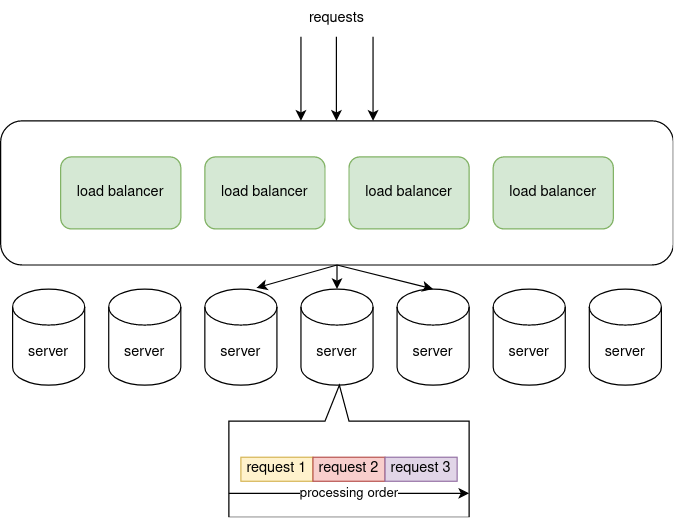

In [1]:
from IPython.display import Image
Image(filename='media/balancers.png') 

Выше изображена архитектура, в рамках которой живут наши балансировщики. Над парком серверов работают идентичные независимые балансировщики нагрузки, распределяющие входящие запросы по серверам. Балансировщики не видят текущее состояние серверов, вместо этого они рассылают по серверам запросы, обновляя видимое им состояние раз в $t$ секунд. Для простоты симуляции сделаны следующие предположения:
- Каждый запрос характеризуется только IP отправителя и идеальной длительностью обработки (реальная длительность равна идеальной, умноженной на коэффициент замедления сервера).
- Каждый сервер обрабатывает запросы последовательно.
- Каждый запрос попадает на случайный балансировщик.

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import subprocess

from pathlib import Path

## Эксперимент 1: централизованный балансировщик

В данном эксперименте мы посмотрим на поведение четырех классических балансировщиков, которые в рамках лабы будут называться Hash, Random, RoundRobin и LeastLoaded. Балансировщики устроены следующим образом:
- **Hash** вычисляет хеш IP-адреса отправителя и маппит этот хеш на множество серверов. В рамках эксперимента множество серверов не меняется, и маппинг соответственно тоже.
- **Random** отправляет запрос на случайный сервер.
- **RoundRobin** выбирает серверы по кругу: первый запрос отправляется на первый сервер, второй отправляется на второй сервер и так далее.
- **LeastLoaded** отправляет запрос на сервер с наименьшим числом необработанных запросов.

Для простоты предположим наличие всего одного балансировщика, обновляющего своё состояние раз в 10 мс. В результате эксперимента выводится график зависимости максимального количества необработанных запросов на одном сервере от времени в логарифмической шкале.

In [3]:
exp1_balancers = ['Hash', 'Random', 'RoundRobin', 'LeastLoaded']

def run_exp1(name, n_balancers=1, settings=[], balancers=exp1_balancers):
    with open('.tmp-config.json', 'w') as f:
        f.write(json.dumps([{'balancer': balancer, 'n_balancers': n_balancers, 'sync_interval': 0.01 if n_balancers == 1 else 5} for balancer in balancers]))
    subprocess.run(['cargo', 'run', '-r', '--', '--dump', '.tmp-result.txt', '--config', '.tmp-config.json', *settings], check=True) 
    results = Path('.tmp-result.txt').read_text().splitlines()
    plt.figure(figsize=(16, 9))
    plt.title(name)
    plt.yscale('log')
    plt.ylabel('max load (requests)')
    plt.xlabel('time (s)')
    for i in range(0, len(results), 3):
        times = list(map(float, results[i + 1].split(',')))
        load = list(map(int, results[i + 2].split(',')))
        plt.plot(times, load, label=balancers[i // 3])
        plt.legend(loc='upper left')
    plt.show()
    Path('.tmp-result.txt').unlink(missing_ok=True)
    Path('.tmp-config.json').unlink(missing_ok=True)


Для начала запустим простейший эксперимент на 100 идентичных серверах.

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json`


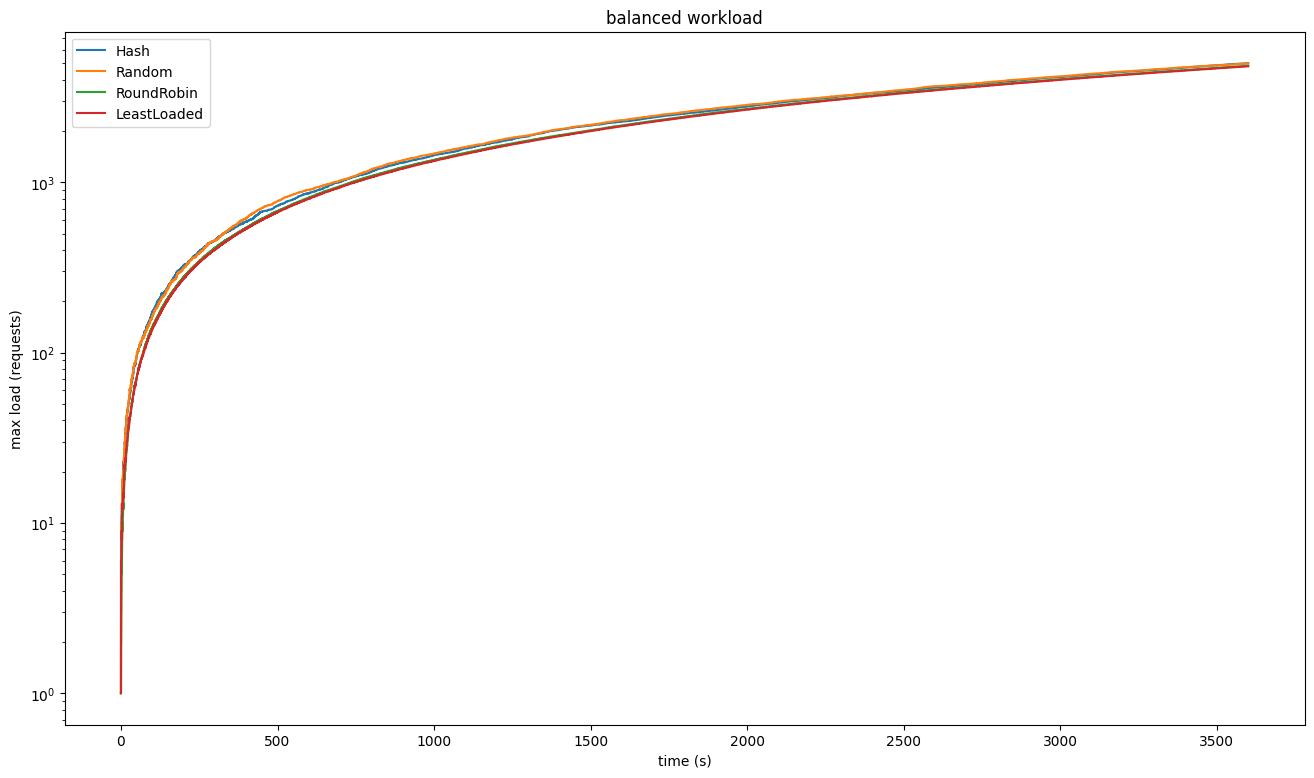

In [4]:
run_exp1('balanced workload')

В эксперименте выше было 200 отправителей, отправляющих сопоставимое число запросов каждый. Что будет, если отправителей будет меньше (например, 10)?

    Finished release [optimized] target(s) in 0.04s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json --senders 10`


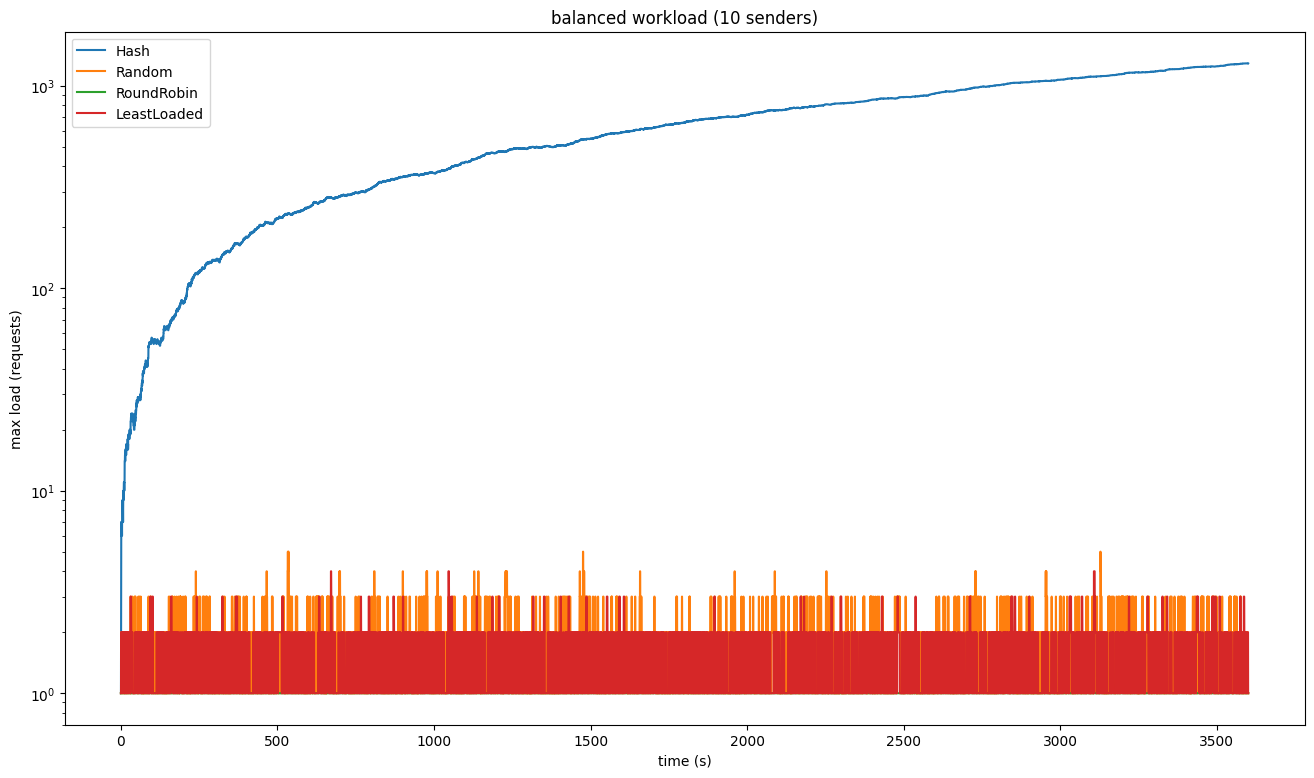

In [5]:
run_exp1('balanced workload (10 senders)', settings=['--senders', '10'])

Теперь немного поменяем данные. Если раньше отправители отправляли сопоставимое количество запросов, то теперь один отправитель будет генерировать сильно больше нагрузки на систему. Подобный паттерн нагрузки -- нормальное явление в облаках.

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json --preset skewed`


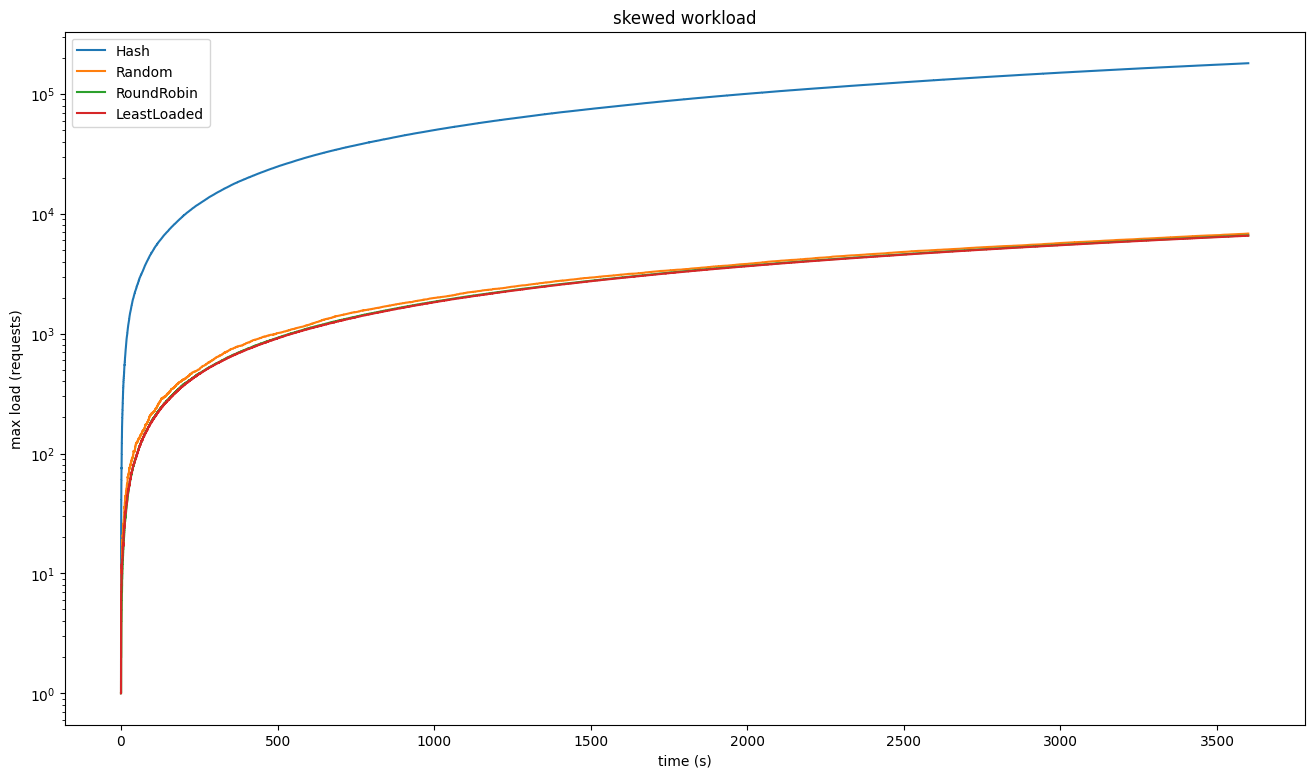

In [6]:
run_exp1('skewed workload', settings=['--preset', 'skewed'])

- Почему поведение хеш-балансировщика так сильно деградирует в последних двух экспериментах?
- В каких случаях вообще выгодно использовать такой балансировщик?

До этого мы рассматривали парк идентичных серверов. Теперь рассмотрим случай, когда 5% серверов медленные.

    Finished release [optimized] target(s) in 0.04s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json --different-servers`


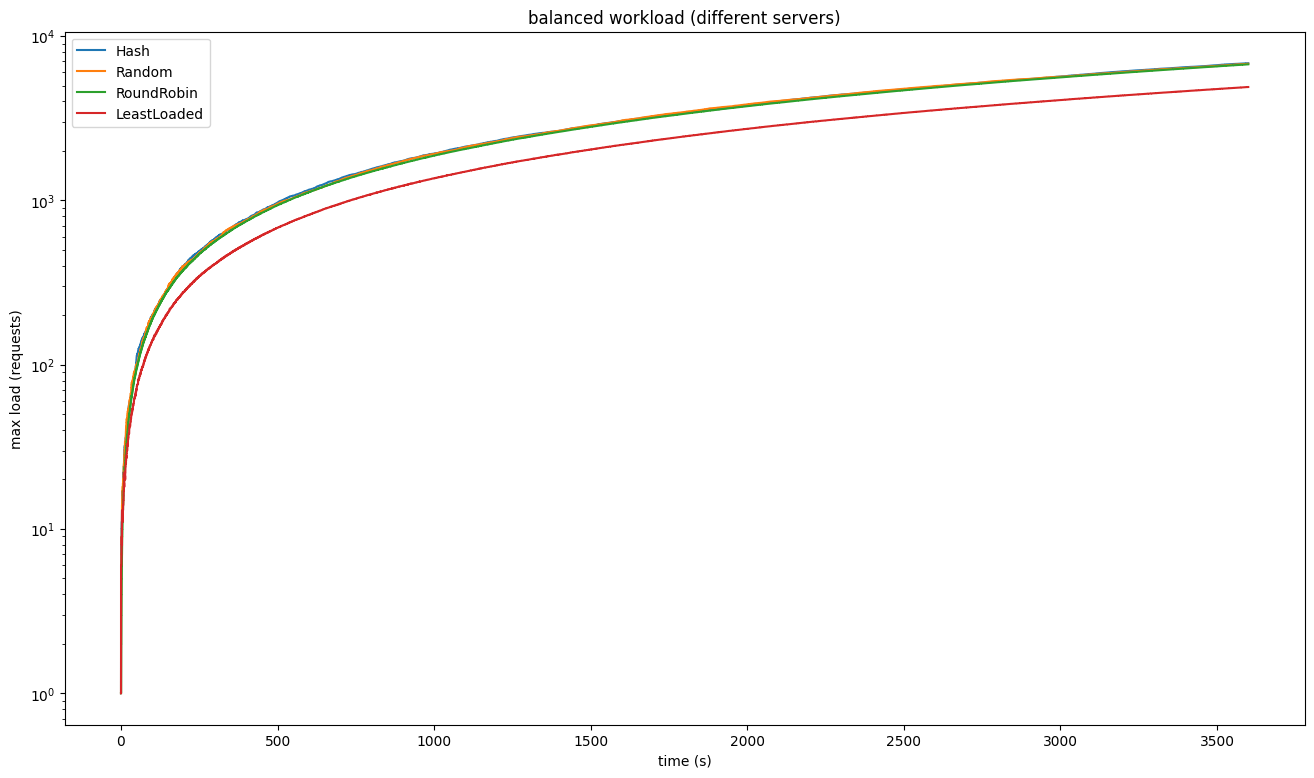

In [7]:
run_exp1('balanced workload (different servers)', settings=['--different-servers'])

- Почему результаты изменились таким образом?

## Эксперимент 2: независимые балансировщики

В предыдущем эксперименте у нас был всего один балансировщик. Теперь предположим наличие нескольких независимых балансировщиков, обновляющих состояние раз в 5 секунд.

- Зачем нужно наличие нескольких независимых балансировщиков?

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json`


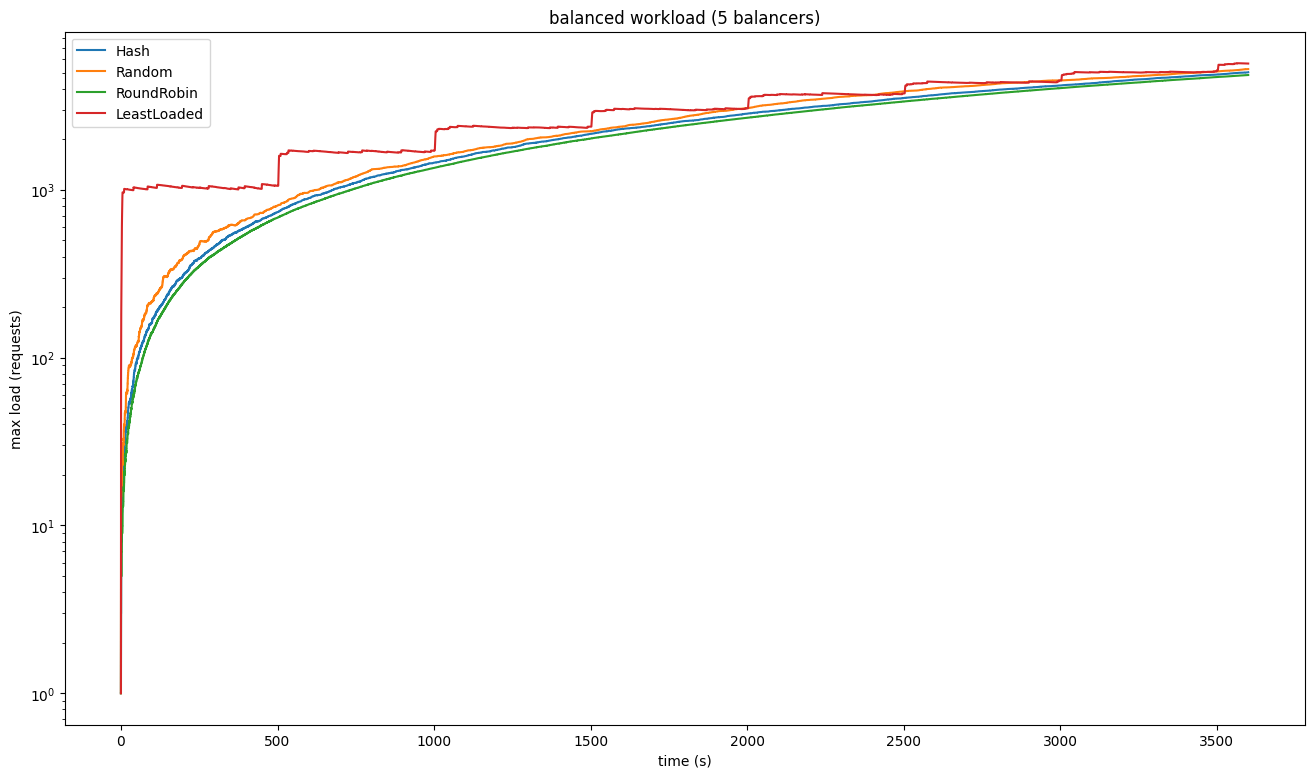

In [8]:
run_exp1('balanced workload (5 balancers)', n_balancers=5)

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json`


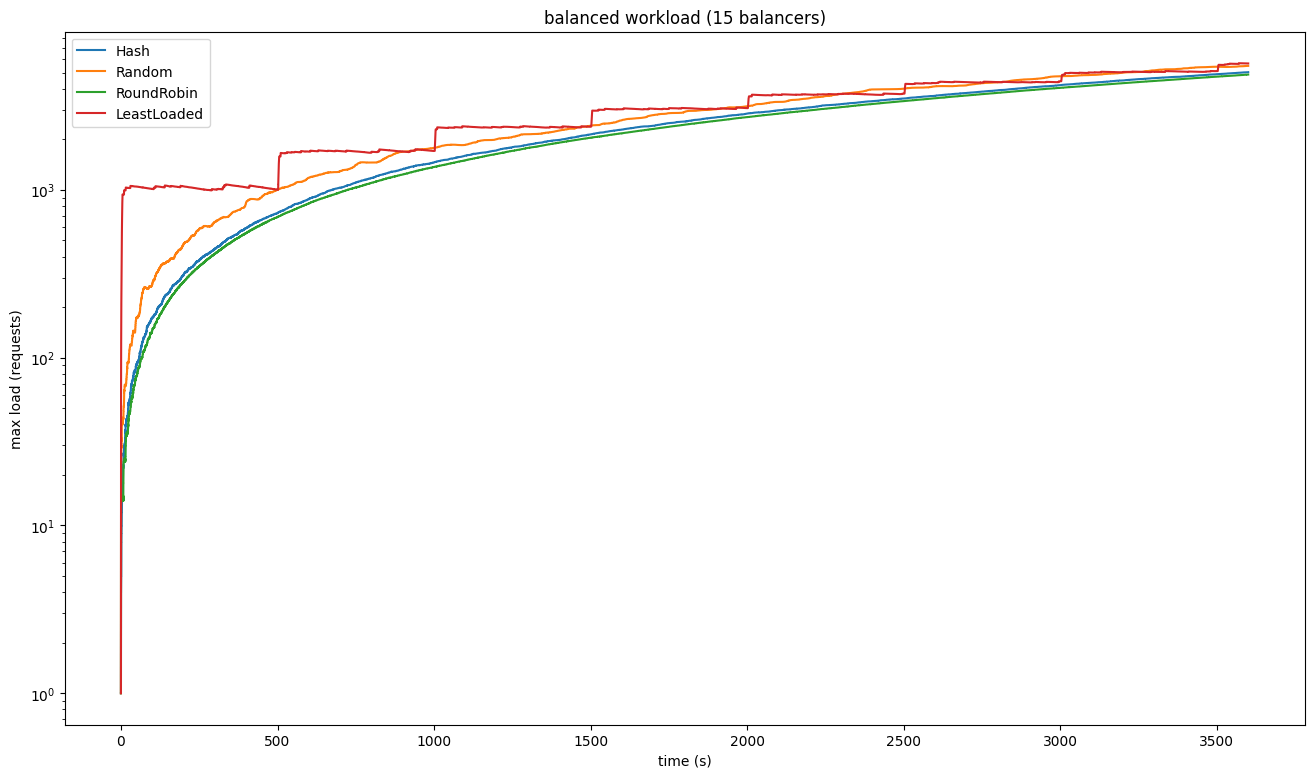

In [9]:
run_exp1('balanced workload (15 balancers)', n_balancers=15)

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json`


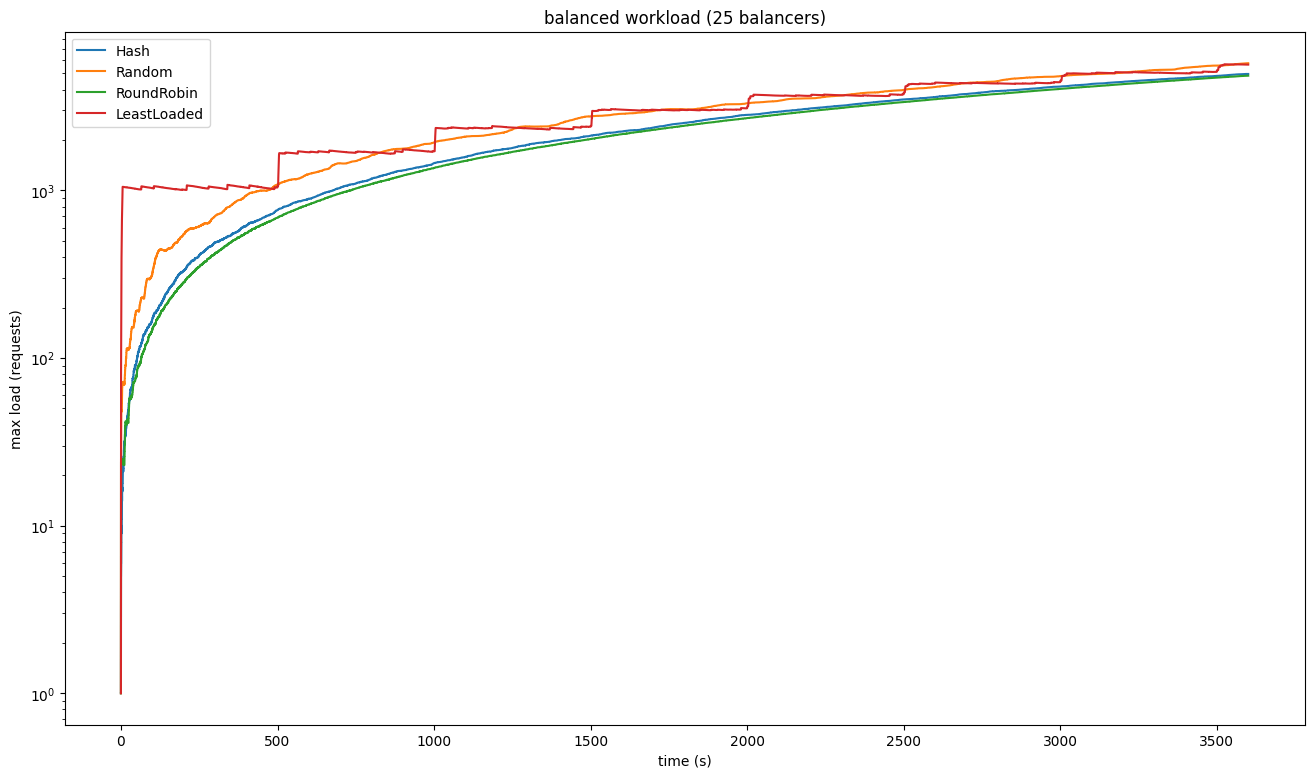

In [10]:
run_exp1('balanced workload (25 balancers)', n_balancers=25)

- Почему поведение **LeastLoaded** балансировщика сильно изменилось, а остальных -- нет?
- **Random** балансировщик немного деградирует с увеличением числа своих копий, хотя по идее не должен. Посмотрите реализацию в файле `src/balancer.rs` и найдите проблему.

## Эксперимент 3: power of 2

В случае одного балансировщика **LeastLoaded** был самым лучшим, но с несколькими копиями его качество сильно деградирует. Как это поправить?

Оказывается, что есть простейшая техника, позволяющая исправить ситуацию. Она называется "power of two choices" и имеет довольно много применений (см. [эту](http://www.eecs.harvard.edu/~michaelm/postscripts/handbook2001.pdf) статью).

Идея заключается в том, что можно выбирать наименее нагруженный сервер не из всех, а из $K$ случайных. При этом даже при $K = 2$ наблюдается значительное улучшение.

Проверим качество алгоритма на том же эксперименте.

In [11]:
exp3_balancers = ['Hash', 'Random', 'RoundRobin', 'LeastLoaded', 'PowerOfK[k=2]']

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json`


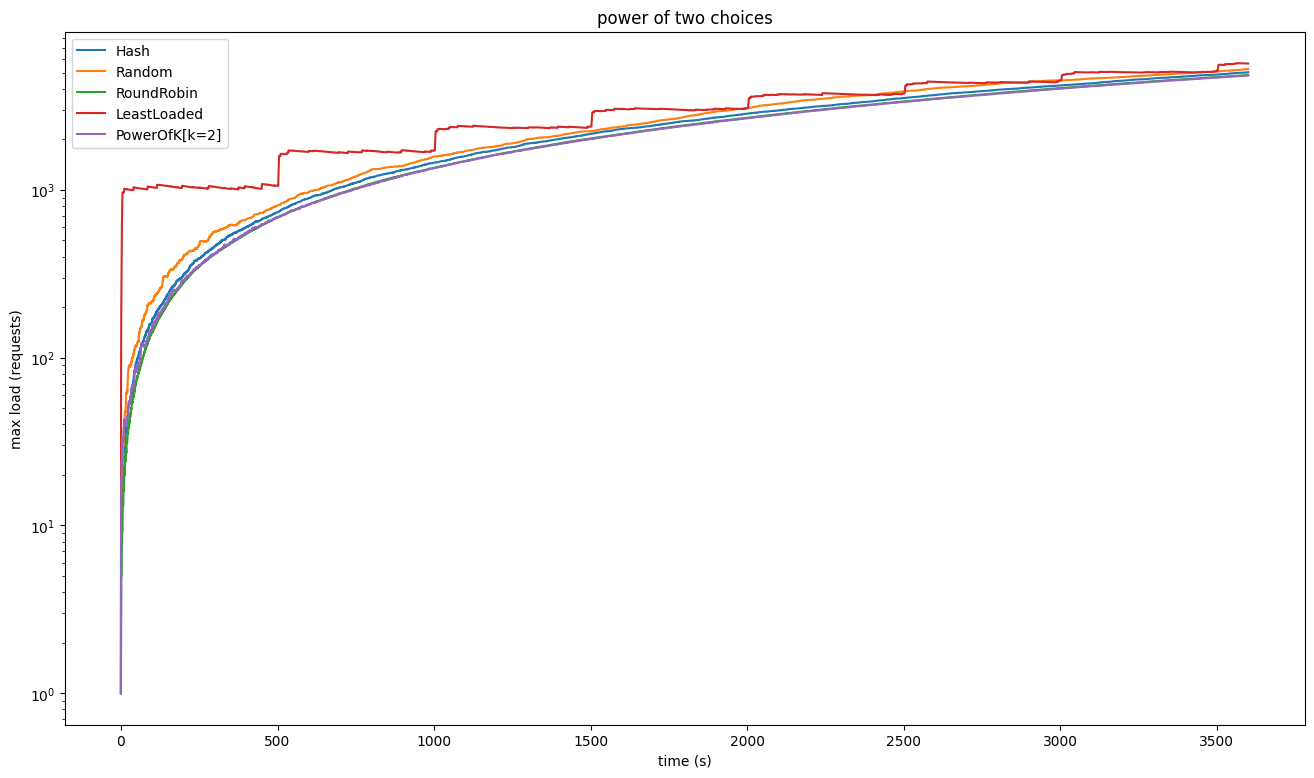

In [12]:
run_exp1('power of two choices', n_balancers=5, balancers=exp3_balancers)

Что будет, если иметь больший выбор? Давайте проверим.

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json`


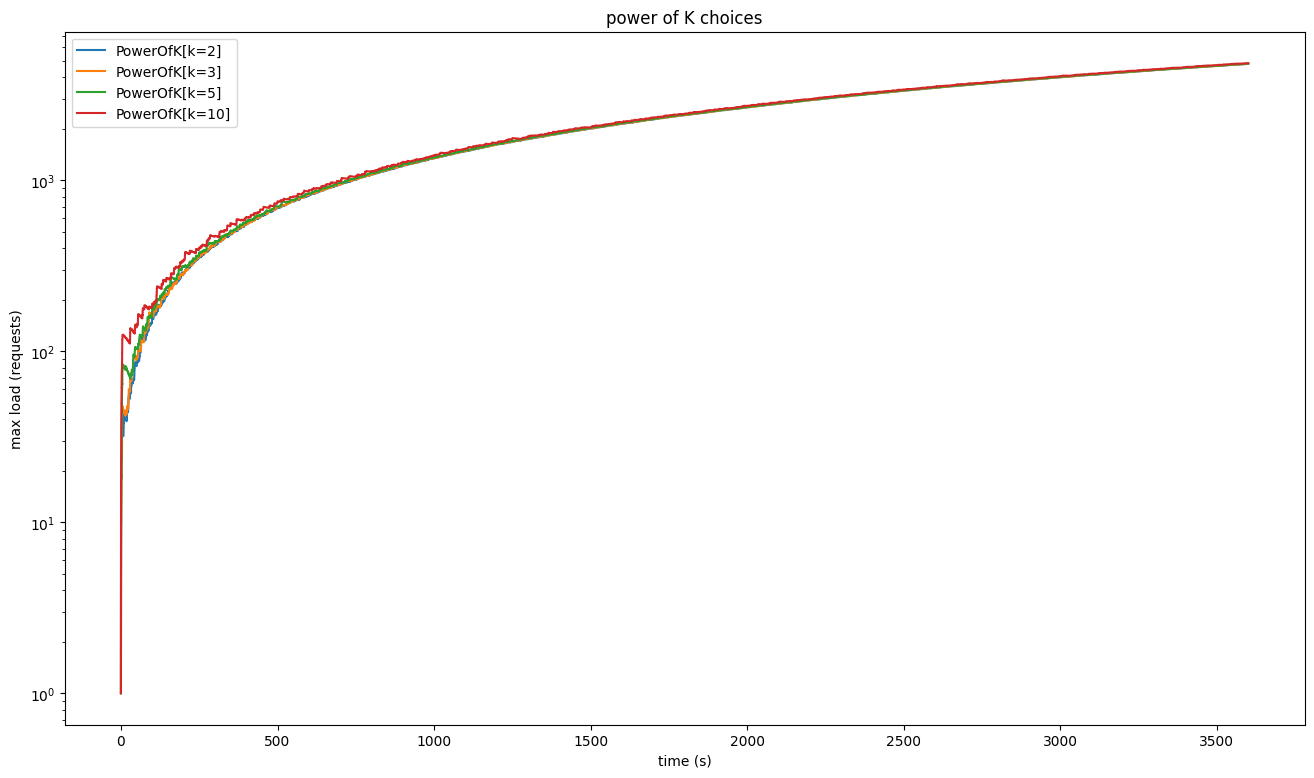

In [13]:
run_exp1('power of K choices', n_balancers=5, balancers=['PowerOfK[k=2]', 'PowerOfK[k=3]', 'PowerOfK[k=5]', 'PowerOfK[k=10]'])

Заметим, что этот планировщик может отправлять запрос на обновление состояния только к выбранным серверам на каждой итерации, не полагаясь на автоматическое обновление раз в 5 секунд. Даст ли это выигрыш?

    Finished release [optimized] target(s) in 0.04s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json`


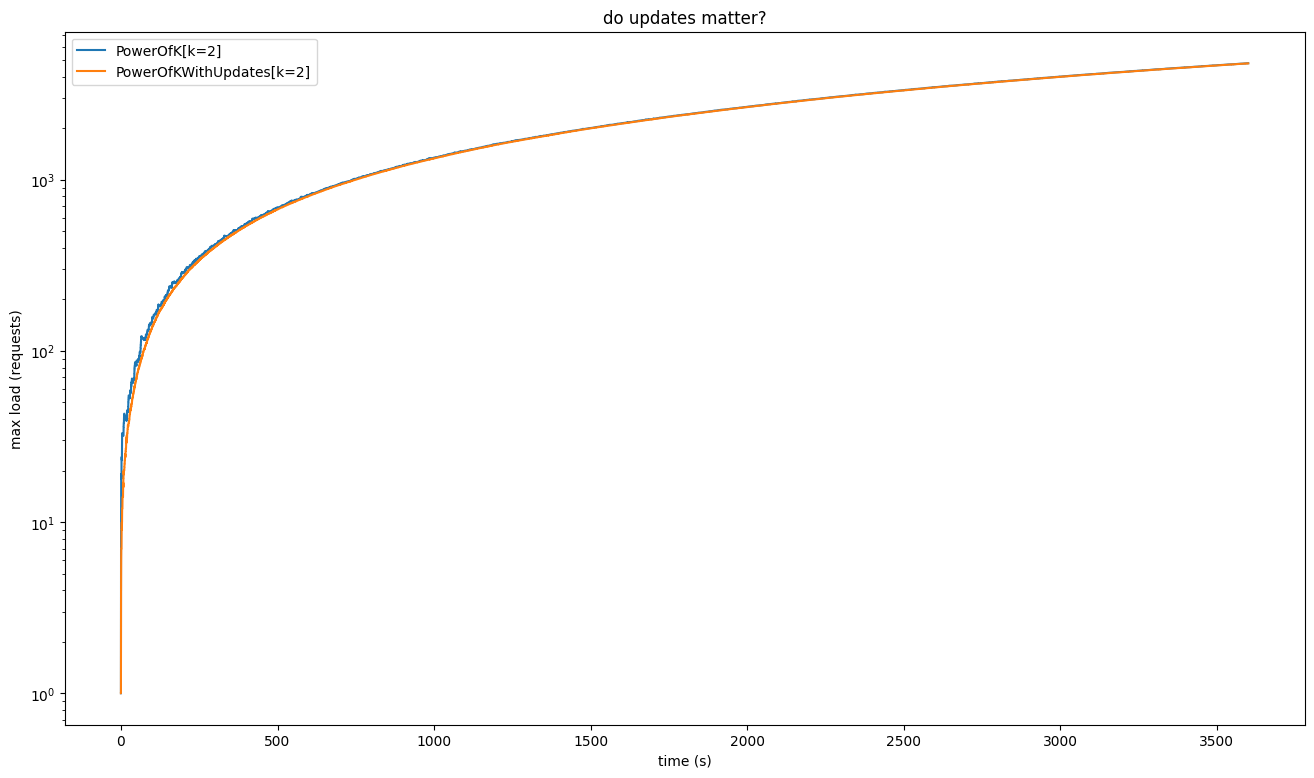

In [14]:
run_exp1('do updates matter?', n_balancers=5, balancers=['PowerOfK[k=2]', 'PowerOfKWithUpdates[k=2]'])

Вспомним, что **LeastLoaded** балансировщик хорошо справлялся с разными по производительности серверами. Сохраняет ли наш новый алгоритм это свойство?

    Finished release [optimized] target(s) in 0.03s
     Running `target/release/load-balancing-lab --dump .tmp-result.txt --config .tmp-config.json --different-servers`


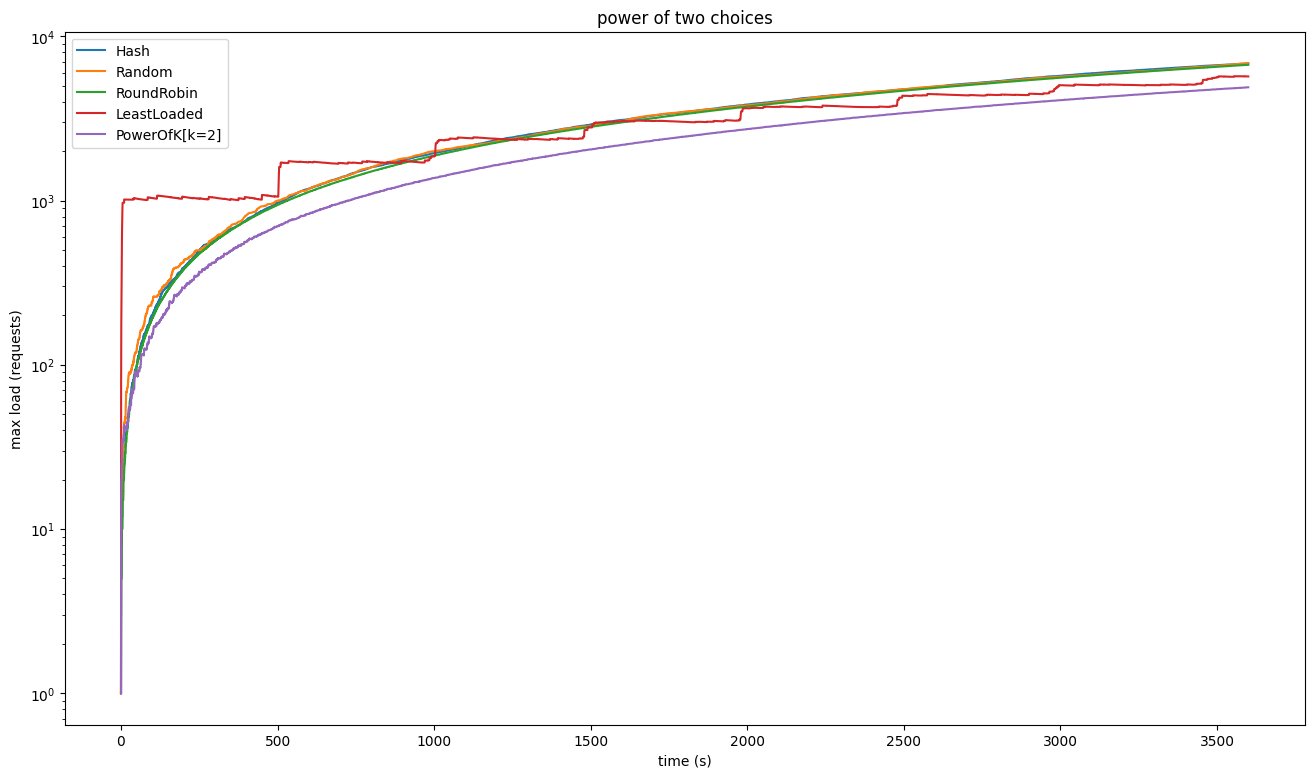

In [15]:
run_exp1('power of two choices', n_balancers=5, balancers=exp3_balancers, settings=['--different-servers'])